# sc_filter_interp
WakenAI switched-cap filter model based on numpy and using interpolation.

___
## Quickstart

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sc_filter_interp as sfi

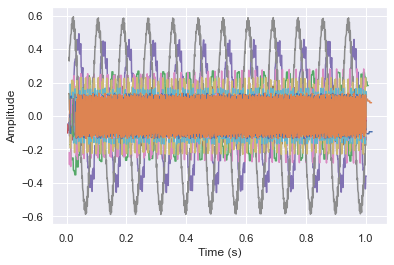

In [2]:
# test signal
fs = 16000.
fsig = 310.
t_vec = np.arange(0, 1, 1/fs)
signal = np.cos(2*np.pi*(310.)*t_vec)

# initilaize filter for this sample rate and with (32-channel) default center frequencies and bandwidths
scfilter = sfi.SCFilter(fs, fc=sfi.CHIP_DFLT_FC, fbw=sfi.CHIP_DFLT_FBW)
output, t_vec_out = scfilter(signal)

plt.figure()
[plt.plot(t, out) for t, out in zip(t_vec_out, output)]
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

---
## Theory

This code models a bank of demodulated bandpass filters specified by their center frequencies (fc) and bandwidths (fbw). We can approximate a given channel as shown in the block diagram below.

<!---
![Approximate model for a singel channel.](demo_files/approx_channel.svg)
-->
<div style="text-align:center"><img src="demo_files/approx_channel.svg" width="700"></div>  

  
Effectively, a signal is bandpass filtered and then demodulated (multiplied by a cos), where the demodulation shifts the filtered chunk of spectra centered at fc, down to 0 Hz (i.e., baseband). In reality, the signal is not multiplied by a perfect sine wave, thus aliases end up in other filter channel outputs. The center frequency and bandwidth are related by `fbw = 3*fc/(np.pi*4*k)`, where k is a programmable chip hardware parameter for each channel. In the demo chip, k is an integer between 2 to 8. However, for simulation pruposes any this code allows non-integer k, and thus arbitrary fbw.

As an example, create a single tone at 310 Hz, sampled at 16 kHz:

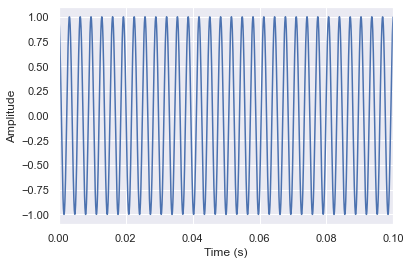

In [3]:
# tone
fs = 16000.
fsig = 310.

t_vec = np.arange(0, 1, 1/fs)
signal = np.cos(2*np.pi*(fsig)*t_vec)

plt.figure()
plt.plot(t_vec, signal)
plt.xlim((0, 0.1))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Now, initialize an SCFilter bank with a single channel, centered at 300 Hz, and a bandwidth of 20 Hz. 

In [4]:
fc = np.array([300.])
fbw = np.array([20.])

scfilter = sfi.SCFilter(fs, len(signal), fc=fc, fbw=fbw)

Filter the signal and plot the output.

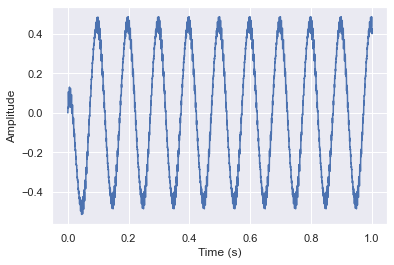

In [5]:
output, t_vec_out = scfilter(signal, out_type='raw')

# output and corresponding time vector come output as array of arrays
plt.figure()
plt.plot(t_vec_out[0], output[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

The output is a 10 Hz tone because the bandpass filter was centered at 300 Hz, and the 310 Hz signal was filtered and downconverted to 310 Hz - 300 Hz = 10 Hz. Note that the signal is attenuated by a little more than 1/2 and there is still some high frequency content present due to non-idealities of the filter and downconversion.

What would happen if the input signal was a tone of 300 Hz - the same as the center frequency of the filter?

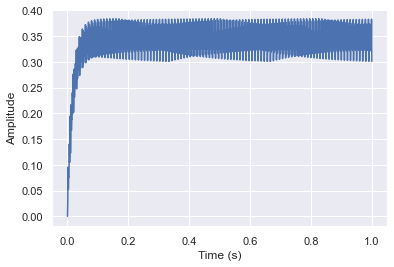

In [6]:
signal = np.cos(2*np.pi*(300.)*t_vec)
output, t_vec_out = scfilter(signal)

plt.figure()
plt.plot(t_vec_out[0], output[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

The output signal is "DC" - a 0 Hz tone, since 300 Hz - 300 Hz = 0 Hz. There is high frequency content, but the dominant signal is 0 Hz. Note that the output also ramps up to the value. This is due to the causality of the filter and the assumption that the signal before time t = 0, is 0.

Recall that we because the demodulation is not perfect, signal content can end up in other filter channels. Consider the case where we have two filter channels: A 300 Hz channel, and a subharmonic, 300 Hz / 3 = 100 Hz.  

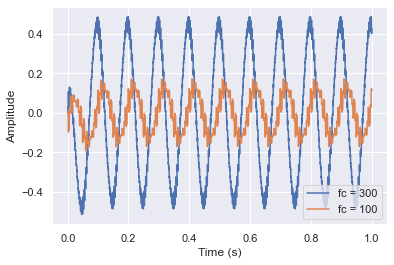

In [7]:
fs = 16000.
fsig = 310.

t_vec = np.arange(0, 1, 1/fs)
signal = np.cos(2*np.pi*(fsig)*t_vec)

fc = np.array([300., 100.])
fbw = np.array([20., 20.])

scfilter = sfi.SCFilter(fs, len(signal), fc=fc, fbw=fbw)

output, t_vec_out = scfilter(signal, out_type='raw')

plt.figure()
plt.plot(t_vec_out[0], output[0])
plt.plot(t_vec_out[1], output[1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(("fc = 300", "fc = 100"))
plt.show()

In this case, we see that a smaller componenent of the 10 Hz tone still appears at the output of this channel. Despite these aliases in different channels, the hypothesis is, that for inference based systems, these types of non-idealities have little effect on accuracy when the non-idealities are accounted for during training.

Using the WakenAI chip default center frequencies and bandwidths (32 channels), and the 310 Hz tone, we see the following output

Chip default channel center frequencies:
[  29.51388889   49.18981481   80.49242424  118.05555556  160.98484848
  196.75925926  265.625       321.96969697  379.46428571  429.29292929
  531.25        643.93939394  708.33333333  787.03703704  965.90909091
 1062.5        1287.87878788 1416.66666667 1574.07407407 1770.83333333
 2125.         2361.11111111 2656.25       3035.71428571 3541.66666667
 3863.63636364 4250.         4722.22222222 5312.5        6071.42857143
 7083.33333333 8500.        ] 

Chip default channel bandwidths:
[2.25469503e+02 3.75782504e+02 6.14916826e+02 1.35281702e+03
 1.84475048e+03 3.00626004e+03 4.05845105e+03 6.14916826e+03
 7.24723402e+03 9.83866921e+03 1.21753531e+04 1.47580038e+04
 1.62338042e+04 2.10438203e+04 2.58265067e+04 2.84091573e+04
 3.44353422e+04 3.78788765e+04 4.20876405e+04 5.41126807e+04
 6.49352168e+04 7.21502409e+04 8.11690210e+04 9.27645954e+04
 1.08225361e+05 1.18064031e+05 1.29870434e+05 1.44300482e+05
 1.62338042e+05 1.85529191e+05 2.16450723

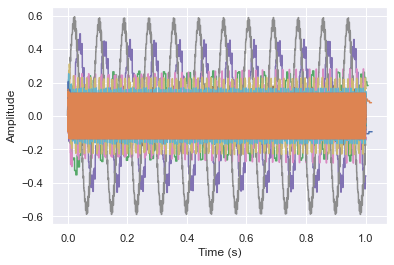

In [8]:
scfilter = sfi.SCFilter(fs, len(t_vec), fc=sfi.CHIP_DFLT_FC, fbw=sfi.CHIP_DFLT_FBW)
output, t_vec_out = scfilter(signal, out_type='raw')

print('Chip default channel center frequencies:')
print(sfi.CHIP_DFLT_FC, '\n')
print('Chip default channel bandwidths:')
print(sfi.CHIP_DFLT_FBW, '\n')

plt.figure()
[plt.plot(t, out) for t, out in zip(t_vec_out, output)]
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

---
## Output Usage

The examples above use the `out_type='raw'` option when filtering. These mimic an analog signal via upsampled channel outputs. The sampling rate varies for each channel and is `sample_rate = 12*fc*over_samp`. Due to the varing sample rates, the output lengths of the channel vectors holding the samples also varies.

In an actual system, the output of each channel is muxed to a single ADC as shown in the diagram below. One sample is taken from the first channel, a second sample from the second channel, and so on. The default per-channel sample rate is 1 kHz (recall the output bandwidth is approximatly `fbb = 300 Hz`).

<div style="text-align:center"><img src="demo_files/fbank_adc.png" width="400"></div>

The default `__call__` method of SCFilter is `out_type='samples'` which mimics the situation in the diagram with a single ADC and a per-channel sample-rate of 1 kHz. To do this sampling, the `__call__` method calls the `sample_sig_chans` method using the `num_samp_kind='max-same'` option which returns the maximum number of samples per channel possible with the same number of samples per channel. The corresponding sampling time points for each channel are also returned.

In [9]:
# test signal
fs = 16000.
fsig = 310.
t_vec = np.arange(0, 1, 1/fs)
signal = np.cos(2*np.pi*(fsig)*t_vec)

# filter bank object
scfilter = sfi.SCFilter(fs, len(t_vec))

# raw
output, t_vec_out = scfilter(signal, out_type='raw')
print(f'With raw signal, the number of samples per channel is:\n {[len(raw_vec) for raw_vec in output]}\n')

# sampled with max number of samples in each channel possible (1 kHz)
output, t_vec_out = scfilter(signal, out_type='raw')
output, t_vec_out = scfilter.sample_sig_chans(output, num_samp_kind='max')
print(f'With sampled signal (num_samp_kind=\'max\'), the number of samples per channel is:\n {[len(raw_vec) for raw_vec in output]}')

# sampled channels, same number of samples per channel (default, 1 kHz)
output, t_vec_out = scfilter(signal, out_type='samples')
print(f'With sampled signal (num_samp_kind=\'max_same\'), the number of samples per channel is:\n {[len(raw_vec) for raw_vec in output]}')

With raw signal, the number of samples per channel is:
 [3620, 6020, 9740, 14180, 19340, 23660, 31940, 38660, 45620, 51620, 63860, 77300, 85100, 94460, 115940, 127580, 154580, 170060, 188900, 212540, 255020, 283340, 318740, 364340, 425060, 463700, 510020, 566660, 637580, 728540, 849980, 1020020]

With sampled signal (num_samp_kind='max'), the number of samples per channel is:
 [1021, 1019, 1008, 1000, 1001, 1002, 1002, 1000, 1001, 1002, 1001, 1000, 1001, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 999, 1000, 1000, 1000, 1000, 999, 1000, 999, 999, 1000]
With sampled signal (num_samp_kind='max_same'), the number of samples per channel is:
 [999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999]


In order to mimic sampling of the output channels, the samp_sig_chans method uses interpolation controlled by the interp_kind parameter. The default is linear interpolation: interp_kind='linear'. Other options include {'quadratic', 'cubic'} splines. These spline options are more accurate, but result in longer simulation times. Depending on needs, the default linear interpolation is likely sufficient.

In [10]:
# get raw samples so we can demonstrate the samp_sig_chans method
output, t_vec_out = scfilter(signal, out_type='raw')

In [11]:
# default using linear interpolation
# same as:
# output, t_vec_out = scfilter(signal)
%timeit out_sampled, t_sampled = scfilter.sample_sig_chans(output, interp_kind='linear')

199 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# using cubic spline interpolation
%timeit out_sampled, t_sampled = scfilter.sample_sig_chans(output, interp_kind='cubic')

2.59 s ± 648 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The model can also be used to make something similar to a power spectrum or fft. The method `calc_chan_energies` does this by computing the mean-square values of each of the channels. This essentially tells you the signal energy in each channel. This function may be used to compute, for example a spectrogram. Recall that due to aliasing artifacts, even if a single tone is present in one band, it will show up in other bands. The energy may be computed on the raw signal or on the sampled signal.

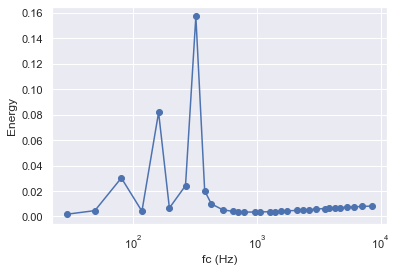

In [13]:
# test signal
fs = 16000.
fsig = 310.
t_vec = np.arange(0, 1, 1/fs)
signal = np.cos(2*np.pi*(fsig)*t_vec)

# filter bank object
scfilter = sfi.SCFilter(fs, len(t_vec))
output, t_vec_out = scfilter(signal)

# compute the energies from the samples of each band
energies = scfilter.calc_chan_energies(output)

plt.figure()
plt.semilogx(sfi.CHIP_DFLT_FC, energies, marker='o')
plt.xlabel('fc (Hz)')
plt.ylabel('Energy')
plt.show()

---
## Creating an Analog Spectrogram

You can use the the model to create something very similar to a spectrogram. When creating a conventional spectrogram from a sampled digital signal, you take sequential windowed FFTs of the input signal with some hop size. For each FFT the magnitude is taken (or squared magnitude) and the phase information discarded. Since the filterbank already gives you the signals within the specified bands (frequency ranges), we need not take an FFT. Instead, we will still apply a sliding window to the output of each filter channel with the specified hop size. Using Parseval's Theorm, we can take the squared sum of the samples within each window, to get an estimated energy within that window for that particular channel. This procedure will effectively give us an output that looks simlar to a spectrogram. 

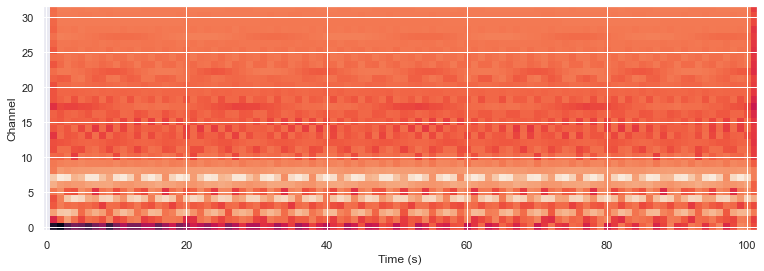

In [14]:
# function that takes a list of the channel signals (must all be the same length) 
# and computes something simlar to a spectrogram.
def analog2spectrogram(channels, win_len, hop_len):
    
    # if win_len % 2 == 0:
    #     raise ValueError(f'win_len must be odd.')
    window = np.hanning(win_len)
    # window needs to be squared since we are taking sum of windowed squares
    window = np.power(window, 2)
    spectrogram = []
    for chan in channels:
        chan = np.power(chan, 2)
        # convolving gives us the windows sum of squares at each sample
        sum_sq = np.convolve(chan, window)
        # downsample based on hop_len
        spectrogram.append(sum_sq[::hop_len])
    # convert to dB
    spectrogram = 10*np.log10(np.array(spectrogram))
    return spectrogram

# test signal
fs = 16000.
fsig = 310.
t_vec = np.arange(0, 1, 1/fs)
signal = np.cos(2*np.pi*(fsig)*t_vec)

# filter bank object
scfilter = sfi.SCFilter(fs, len(t_vec))
# default output gives us 32 channels at 1K samples per second
output, _ = scfilter(signal)

# get spectrogram approximation (50% overlap)
spectrogram = analog2spectrogram(output, 20, 10)

plt.figure(figsize=(2*6.4, 2*4.8))
plt.imshow(spectrogram, origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.show()
